In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
import random
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.05, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        print(test_ratio)
        test_size = int(test_ratio * len(dataset))
        print(test_size)
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size

        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(x.size())
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuracy': train_acc,
                   f'{name} validationaccuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()
def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([8, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([8, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([9, 4, 50])
Epoch 1: Training accuracy: 49.72627639770508 Testing 

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuracy,▁▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
centralized validationaccuracy,▁▂▂▄▃▅▄▆▆▅▆▆▆▆▇▆▆▇▇▇▇▆▇▇▇▇▇▇█▇▇▇▇█▇▇█▇██
centralized training accuracy,92.06204
centralized validationaccuracy,78.10219


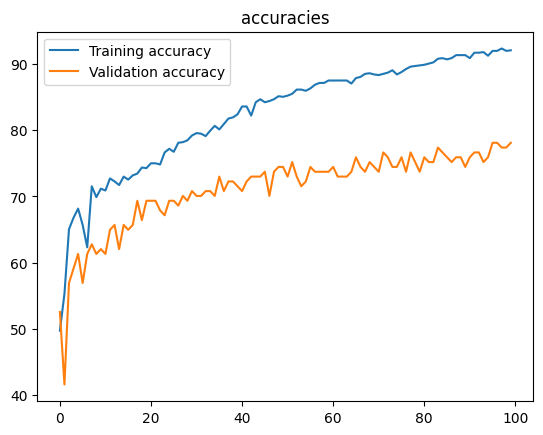

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, valloader, configuration, configuration['epochs'], name= 'centralized')
    loss, accuracy = test(net, testloader, configuration)
    print(f"Epoch {epoch+1}: Test loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

# Federated Learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

0.1499999999999999
250
0.1499999999999999
233
0.1499999999999999
310
0.1499999999999999
253


In [8]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FL unified",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [11]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [13]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-17 23:11:45,487	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 58663045939.0, 'node:__internal_head__': 1.0, 'memory': 126880440525.0, 'node:192.168.1.146': 1.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'CPU': 32.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.04061305522918701 / accuracy 52.1988525390625
(ClientAppActor pid=111620) 
(ClientAppActor pid=111620) Epoch 1/100
(ClientAppActor pid=111620) Epoch 1: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=111620) Epoch 2: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=111620) Epoch 3: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=111620) Epoch 4: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=111620) Epoch 5: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=111620) Epoch 6: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=111620) Epoch 7: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.04087363972383387, {'accuracy': tensor(47.8011, device='cuda:0')}, 4.976803353999912)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04087363972383387 / accuracy 47.8011474609375
(ClientAppActor pid=111620)  [repeated 570x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=111620) Epoch 83/100 [repeated 570x across cluster]
(ClientAppActor pid=111620) Epoch 99: Training accuracy: 53.19905090332031 Testing accuracy: 46.22641372680664. [repeated 599x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.040865796453812546, {'accuracy': tensor(47.8011, device='cuda:0')}, 8.152426681999714)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.040865796453812546 / accuracy 47.8011474609375


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.04066482011009665, {'accuracy': tensor(58.8910, device='cuda:0')}, 11.417482281000048)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04066482011009665 / accuracy 58.891014099121094
(ClientAppActor pid=111620)  [repeated 636x across cluster]
(ClientAppActor pid=111620) Epoch 7/100 [repeated 636x across cluster]
(ClientAppActor pid=111620) Epoch 29: Training accuracy: 70.95761108398438 Testing accuracy: 66.25. [repeated 640x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.04020113804761101, {'accuracy': tensor(64.8184, device='cuda:0')}, 14.818388400000003)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04020113804761101 / accuracy 64.818359375
(ClientAppActor pid=111620)  [repeated 596x across cluster]
(ClientAppActor pid=111620) Epoch 18/100 [repeated 596x across cluster]
(ClientAppActor pid=111620) Epoch 40: Training accuracy: 71.1146011352539 Testing accuracy: 64.375. [repeated 593x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.03898245096206665, {'accuracy': tensor(68.4512, device='cuda:0')}, 18.31854379699962)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03898245096206665 / accuracy 68.45124053955078


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.03690086392795339, {'accuracy': tensor(73.2314, device='cuda:0')}, 21.809196725999755)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=111621)  [repeated 588x across cluster]
(ClientAppActor pid=111621) Epoch 91/100 [repeated 588x across cluster]
Server-side evaluation loss 0.03690086392795339 / accuracy 73.23135375976562
(ClientAppActor pid=111620) Epoch 7: Training accuracy: 72.83406829833984 Testing accuracy: 69.59064483642578. [repeated 568x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.03572145279716043, {'accuracy': tensor(71.8929, device='cuda:0')}, 25.338979009000013)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03572145279716043 / accuracy 71.89292907714844
(ClientAppActor pid=111620)  [repeated 571x across cluster]
(ClientAppActor pid=111620) Epoch 96/100 [repeated 571x across cluster]
(ClientAppActor pid=111620) Epoch 13: Training accuracy: 73.18840789794922 Testing accuracy: 72.83236694335938. [repeated 585x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.034410778213949764, {'accuracy': tensor(74.3786, device='cuda:0')}, 28.72256302100004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.034410778213949764 / accuracy 74.37858581542969


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.034541428089141846, {'accuracy': tensor(70.6501, device='cuda:0')}, 32.024017807999826)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=111620)  [repeated 630x across cluster]
(ClientAppActor pid=111620) Epoch 92/100 [repeated 630x across cluster]
Server-side evaluation loss 0.034541428089141846 / accuracy 70.65009307861328


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=111620) Epoch 1: Training accuracy: 72.98577880859375 Testing accuracy: 67.92453002929688. [repeated 609x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.0337974604438333, {'accuracy': tensor(71.9885, device='cuda:0')}, 35.36317774899999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0337974604438333 / accuracy 71.988525390625
(ClientAppActor pid=111620)  [repeated 580x across cluster]
(ClientAppActor pid=111620) Epoch 100/100 [repeated 580x across cluster]
(ClientAppActor pid=111620) Epoch 21: Training accuracy: 78.02198028564453 Testing accuracy: 66.875. [repeated 608x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.03300969039692598, {'accuracy': tensor(73.9962, device='cuda:0')}, 38.86268741899994)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03300969039692598 / accuracy 73.99617767333984
(ClientAppActor pid=111620)  [repeated 610x across cluster]
(ClientAppActor pid=111620) Epoch 82/100 [repeated 610x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.03283454039517571, {'accuracy': tensor(73.5182, device='cuda:0')}, 42.222611204999794)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03283454039517571 / accuracy 73.5181655883789
(ClientAppActor pid=111620) Epoch 100: Training accuracy: 74.20289611816406 Testing accuracy: 73.98844146728516. [repeated 591x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.03244698748869054, {'accuracy': tensor(73.9962, device='cuda:0')}, 45.65257819499993)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03244698748869054 / accuracy 73.99617767333984
(ClientAppActor pid=111620)  [repeated 587x across cluster]
(ClientAppActor pid=111620) Epoch 2/100 [repeated 587x across cluster]
(ClientAppActor pid=111620) Epoch 14: Training accuracy: 75.21739196777344 Testing accuracy: 75.72254180908203. [repeated 591x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.032434445970198685, {'accuracy': tensor(73.5182, device='cuda:0')}, 49.17438830999981)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032434445970198685 / accuracy 73.5181655883789
(ClientAppActor pid=111620)  [repeated 593x across cluster]
(ClientAppActor pid=111620) Epoch 100/100 [repeated 593x across cluster]
(ClientAppActor pid=111621) Epoch 83: Training accuracy: 78.02198028564453 Testing accuracy: 65.625. [repeated 592x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.03323434380924001, {'accuracy': tensor(72.8489, device='cuda:0')}, 52.52244296699973)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03323434380924001 / accuracy 72.84894561767578


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.03318297161775477, {'accuracy': tensor(72.6577, device='cuda:0')}, 55.825682863999646)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03318297161775477 / accuracy 72.65774536132812
(ClientAppActor pid=111620)  [repeated 582x across cluster]
(ClientAppActor pid=111620) Epoch 86/100 [repeated 582x across cluster]
(ClientAppActor pid=111620) Epoch 99: Training accuracy: 75.18355560302734 Testing accuracy: 74.26900482177734. [repeated 584x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.03276956432005938, {'accuracy': tensor(73.3270, device='cuda:0')}, 59.38494835199981)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03276956432005938 / accuracy 73.32695770263672
(ClientAppActor pid=111620)  [repeated 598x across cluster]
(ClientAppActor pid=111620) Epoch 90/100 [repeated 598x across cluster]
(ClientAppActor pid=111620) Epoch 100: Training accuracy: 73.86196899414062 Testing accuracy: 74.85379791259766. [repeated 594x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.032276791684767776, {'accuracy': tensor(73.1358, device='cuda:0')}, 62.94135256799973)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032276791684767776 / accuracy 73.13575744628906


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.032018349451177264, {'accuracy': tensor(73.5182, device='cuda:0')}, 66.35713974099963)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032018349451177264 / accuracy 73.5181655883789
(ClientAppActor pid=111620)  [repeated 554x across cluster]
(ClientAppActor pid=111620) Epoch 55/100 [repeated 554x across cluster]
(ClientAppActor pid=111620) Epoch 69: Training accuracy: 77.864990234375 Testing accuracy: 68.125. [repeated 561x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.032182458569021785, {'accuracy': tensor(73.5182, device='cuda:0')}, 69.57885201399995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032182458569021785 / accuracy 73.5181655883789
(ClientAppActor pid=111620)  [repeated 619x across cluster]
(ClientAppActor pid=111620) Epoch 70/100 [repeated 619x across cluster]
(ClientAppActor pid=111620) Epoch 85: Training accuracy: 79.27786254882812 Testing accuracy: 70.0. [repeated 618x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.03346345354528988, {'accuracy': tensor(72.7533, device='cuda:0')}, 73.17079392000005)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03346345354528988 / accuracy 72.75334930419922


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.03159744949901805, {'accuracy': tensor(73.9962, device='cuda:0')}, 76.78707102199996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03159744949901805 / accuracy 73.99617767333984
(ClientAppActor pid=111620)  [repeated 523x across cluster]
(ClientAppActor pid=111620) Epoch 24/100 [repeated 523x across cluster]
(ClientAppActor pid=111620) Epoch 37: Training accuracy: 76.6091079711914 Testing accuracy: 65.625. [repeated 521x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.03220622679766487, {'accuracy': tensor(73.5182, device='cuda:0')}, 80.08876039400002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03220622679766487 / accuracy 73.5181655883789
(ClientAppActor pid=111620)  [repeated 635x across cluster]
(ClientAppActor pid=111620) Epoch 43/100 [repeated 635x across cluster]
(ClientAppActor pid=111620) Epoch 57: Training accuracy: 75.79710388183594 Testing accuracy: 77.45664978027344. [repeated 635x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.03244620912215289, {'accuracy': tensor(73.3270, device='cuda:0')}, 83.57396357699963)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03244620912215289 / accuracy 73.32695770263672


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.030658974367029527, {'accuracy': tensor(75.5258, device='cuda:0')}, 87.07493331299975)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030658974367029527 / accuracy 75.52581024169922
(ClientAppActor pid=111620)  [repeated 538x across cluster]
(ClientAppActor pid=111620) Epoch 8/100 [repeated 538x across cluster]
(ClientAppActor pid=111620) Epoch 19: Training accuracy: 75.35545349121094 Testing accuracy: 70.28302001953125. [repeated 538x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.030642323634203744, {'accuracy': tensor(75.2390, device='cuda:0')}, 90.38759914499997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030642323634203744 / accuracy 75.23900604248047
(ClientAppActor pid=111620)  [repeated 639x across cluster]
(ClientAppActor pid=111620) Epoch 21/100 [repeated 639x across cluster]
(ClientAppActor pid=111620) Epoch 31: Training accuracy: 74.76303100585938 Testing accuracy: 72.16981506347656. [repeated 639x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.03176791177076452, {'accuracy': tensor(74.4742, device='cuda:0')}, 93.84813398699998)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03176791177076452 / accuracy 74.47418975830078
(ClientAppActor pid=111620)  [repeated 416x across cluster]
(ClientAppActor pid=111620) Epoch 33/100 [repeated 415x across cluster]
(ClientAppActor pid=111620) Epoch 43: Training accuracy: 76.23188781738281 Testing accuracy: 76.87861633300781. [repeated 403x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.0312154538491193, {'accuracy': tensor(74.7610, device='cuda:0')}, 98.97549359100003)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0312154538491193 / accuracy 74.76099395751953
(ClientAppActor pid=111620)  [repeated 360x across cluster]
(ClientAppActor pid=111620) Epoch 1/100 [repeated 360x across cluster]
(ClientAppActor pid=111620) Epoch 8: Training accuracy: 76.3768081665039 Testing accuracy: 76.87861633300781. [repeated 361x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.031325515578774846, {'accuracy': tensor(74.4742, device='cuda:0')}, 104.92125579999993)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031325515578774846 / accuracy 74.47418975830078
(ClientAppActor pid=111620)  [repeated 276x across cluster]
(ClientAppActor pid=111620) Epoch 36/100 [repeated 276x across cluster]
(ClientAppActor pid=111620) Epoch 38: Training accuracy: 77.2393569946289 Testing accuracy: 77.77777862548828. [repeated 266x across cluster]
(ClientAppActor pid=111620)  [repeated 74x across cluster]
(ClientAppActor pid=111620) Epoch 84/100 [repeated 74x across cluster]
(ClientAppActor pid=111620) Epoch 85: Training accuracy: 77.67988586425781 Testing accuracy: 77.77777862548828. [repeated 73x across cluster]
(ClientAppActor pid=111620)  [repeated 99x across cluster]
(ClientAppActor pid=111620) Epoch 65/100 [repeated 99x across cluster]
(ClientAppActor pid=111620) Epoch 72: Training accuracy: 76.81159210205078 Testing accuracy: 76.87861633300781. [repeated 105x across cluster]
(ClientAppActor pid=111621)  [repeated 53x across cluster]
(ClientAppActor pid=111621) Epoch 27/100 [re

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.030685705297133502, {'accuracy': tensor(75.3346, device='cuda:0')}, 127.06158252299974)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030685705297133502 / accuracy 75.33460998535156
(ClientAppActor pid=111620)  [repeated 121x across cluster]
(ClientAppActor pid=111620) Epoch 32/100 [repeated 121x across cluster]
(ClientAppActor pid=111620) Epoch 42: Training accuracy: 76.1848373413086 Testing accuracy: 69.3396224975586. [repeated 135x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.03148484931272619, {'accuracy': tensor(74.3786, device='cuda:0')}, 131.29111183299983)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03148484931272619 / accuracy 74.37858581542969
(ClientAppActor pid=111620)  [repeated 524x across cluster]
(ClientAppActor pid=111620) Epoch 85/100 [repeated 524x across cluster]
(ClientAppActor pid=111620) Epoch 94: Training accuracy: 79.90580749511719 Testing accuracy: 71.25. [repeated 529x across cluster]
(ClientAppActor pid=111620)  [repeated 128x across cluster]
(ClientAppActor pid=111620) Epoch 36/100 [repeated 128x across cluster]
(ClientAppActor pid=111620) Epoch 36: Training accuracy: 74.52606964111328 Testing accuracy: 72.64151000976562. [repeated 108x across cluster]
(ClientAppActor pid=111621)  [repeated 86x across cluster]
(ClientAppActor pid=111621) Epoch 86/100 [repeated 86x across cluster]
(ClientAppActor pid=111621) Epoch 86: Training accuracy: 77.2393569946289 Testing accuracy: 78.9473648071289. [repeated 87x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.03200806239072014, {'accuracy': tensor(74.0918, device='cuda:0')}, 146.79507135599988)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03200806239072014 / accuracy 74.09178161621094


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=111620)  [repeated 72x across cluster]
(ClientAppActor pid=111620) Epoch 55/100 [repeated 72x across cluster]
(ClientAppActor pid=111620) Epoch 66: Training accuracy: 77.10144805908203 Testing accuracy: 76.30057525634766. [repeated 83x across cluster]
(ClientAppActor pid=111621)  [repeated 312x across cluster]
(ClientAppActor pid=111621) Epoch 70/100 [repeated 312x across cluster]
(ClientAppActor pid=111621) Epoch 74: Training accuracy: 76.89573669433594 Testing accuracy: 70.75471496582031. [repeated 305x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.03022051909390618, {'accuracy': tensor(76.1950, device='cuda:0')}, 154.5315228669997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03022051909390618 / accuracy 76.19503021240234
(ClientAppActor pid=111620)  [repeated 394x across cluster]
(ClientAppActor pid=111620) Epoch 64/100 [repeated 394x across cluster]
(ClientAppActor pid=111620) Epoch 66: Training accuracy: 79.12088012695312 Testing accuracy: 68.125. [repeated 392x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.030430849860696232, {'accuracy': tensor(75.6214, device='cuda:0')}, 161.37256367300006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030430849860696232 / accuracy 75.62141418457031
(ClientAppActor pid=111620)  [repeated 83x across cluster]
(ClientAppActor pid=111620) Epoch 41/100 [repeated 83x across cluster]
(ClientAppActor pid=111620) Epoch 46: Training accuracy: 77.39130401611328 Testing accuracy: 77.45664978027344. [repeated 86x across cluster]
(ClientAppActor pid=111620)  [repeated 146x across cluster]
(ClientAppActor pid=111620) Epoch 63/100 [repeated 146x across cluster]
(ClientAppActor pid=111620) Epoch 68: Training accuracy: 76.30331420898438 Testing accuracy: 73.11320495605469. [repeated 146x across cluster]
(ClientAppActor pid=111621)  [repeated 166x across cluster]
(ClientAppActor pid=111621) Epoch 59/100 [repeated 166x across cluster]
(ClientAppActor pid=111621) Epoch 62: Training accuracy: 79.74882507324219 Testing accuracy: 70.0. [repeated 164x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.031007072504828957, {'accuracy': tensor(74.9522, device='cuda:0')}, 174.32209895000005)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031007072504828957 / accuracy 74.95220184326172


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.03216384438907399, {'accuracy': tensor(73.4226, device='cuda:0')}, 178.0311056659998)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03216384438907399 / accuracy 73.42256164550781
(ClientAppActor pid=111620)  [repeated 443x across cluster]
(ClientAppActor pid=111620) Epoch 2/100 [repeated 443x across cluster]
(ClientAppActor pid=111620) Epoch 6: Training accuracy: 76.1848373413086 Testing accuracy: 70.75471496582031. [repeated 458x across cluster]
(ClientAppActor pid=111620)  [repeated 116x across cluster]
(ClientAppActor pid=111620) Epoch 45/100 [repeated 116x across cluster]
(ClientAppActor pid=111620) Epoch 46: Training accuracy: 76.42179870605469 Testing accuracy: 74.05660247802734. [repeated 100x across cluster]
(ClientAppActor pid=111620)  [repeated 62x across cluster]
(ClientAppActor pid=111620) Epoch 83/100 [repeated 62x across cluster]
(ClientAppActor pid=111620) Epoch 85: Training accuracy: 77.25118255615234 Testing accuracy: 72.64151000976562. [repeated 62x across cluster]
(ClientAppActor pid=111621)  [repeated 139x across cluster]
(ClientAppActor pid=111621) Epoch 19/100 [re

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.031231631250942454, {'accuracy': tensor(74.6654, device='cuda:0')}, 197.63427599199986)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031231631250942454 / accuracy 74.66539001464844
(ClientAppActor pid=111620)  [repeated 131x across cluster]
(ClientAppActor pid=111620) Epoch 34/100 [repeated 131x across cluster]
(ClientAppActor pid=111620) Epoch 43: Training accuracy: 77.01422119140625 Testing accuracy: 72.64151000976562. [repeated 144x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.030451967435724595, {'accuracy': tensor(75.3346, device='cuda:0')}, 202.14251331599962)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030451967435724595 / accuracy 75.33460998535156
(ClientAppActor pid=111620)  [repeated 424x across cluster]
(ClientAppActor pid=111620) Epoch 30/100 [repeated 424x across cluster]
(ClientAppActor pid=111620) Epoch 30: Training accuracy: 77.82608795166016 Testing accuracy: 79.19075012207031. [repeated 415x across cluster]
(ClientAppActor pid=111620)  [repeated 118x across cluster]
(ClientAppActor pid=111620) Epoch 14/100 [repeated 118x across cluster]
(ClientAppActor pid=111620) Epoch 19: Training accuracy: 79.27786254882812 Testing accuracy: 68.75. [repeated 118x across cluster]
(ClientAppActor pid=111620)  [repeated 153x across cluster]
(ClientAppActor pid=111620) Epoch 46/100 [repeated 153x across cluster]
(ClientAppActor pid=111620) Epoch 52: Training accuracy: 75.82938385009766 Testing accuracy: 73.11320495605469. [repeated 155x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.03033463393940645, {'accuracy': tensor(75.7170, device='cuda:0')}, 214.69273333399997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03033463393940645 / accuracy 75.7170181274414
(ClientAppActor pid=111620)  [repeated 261x across cluster]
(ClientAppActor pid=111620) Epoch 79/100 [repeated 261x across cluster]
(ClientAppActor pid=111620) Epoch 93: Training accuracy: 81.16169738769531 Testing accuracy: 72.5. [repeated 269x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.03144666026620304, {'accuracy': tensor(74.2830, device='cuda:0')}, 221.82698671199978)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03144666026620304 / accuracy 74.2829818725586
(ClientAppActor pid=111620)  [repeated 375x across cluster]
(ClientAppActor pid=111620) Epoch 81/100 [repeated 375x across cluster]
(ClientAppActor pid=111620) Epoch 91: Training accuracy: 75.94786834716797 Testing accuracy: 73.58490753173828. [repeated 374x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.031103579437031466, {'accuracy': tensor(74.9522, device='cuda:0')}, 226.07375298399984)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031103579437031466 / accuracy 74.95220184326172
(ClientAppActor pid=111620)  [repeated 311x across cluster]
(ClientAppActor pid=111620) Epoch 26/100 [repeated 311x across cluster]
(ClientAppActor pid=111620) Epoch 27: Training accuracy: 77.36966705322266 Testing accuracy: 74.05660247802734. [repeated 299x across cluster]
(ClientAppActor pid=111620)  [repeated 62x across cluster]
(ClientAppActor pid=111620) Epoch 64/100 [repeated 62x across cluster]
(ClientAppActor pid=111620) Epoch 64: Training accuracy: 77.48815155029297 Testing accuracy: 70.75471496582031. [repeated 61x across cluster]
(ClientAppActor pid=111621)  [repeated 158x across cluster]
(ClientAppActor pid=111621) Epoch 12/100 [repeated 158x across cluster]
(ClientAppActor pid=111621) Epoch 11: Training accuracy: 79.73567962646484 Testing accuracy: 81.28655242919922. [repeated 157x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.030648820540484262, {'accuracy': tensor(75.7170, device='cuda:0')}, 243.18659650900008)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030648820540484262 / accuracy 75.7170181274414
(ClientAppActor pid=111620)  [repeated 173x across cluster]
(ClientAppActor pid=111620) Epoch 39/100 [repeated 173x across cluster]
(ClientAppActor pid=111620) Epoch 38: Training accuracy: 76.89573669433594 Testing accuracy: 73.58490753173828. [repeated 172x across cluster]
(ClientAppActor pid=111620)  [repeated 263x across cluster]
(ClientAppActor pid=111620) Epoch 48/100 [repeated 263x across cluster]
(ClientAppActor pid=111620) Epoch 47: Training accuracy: 78.55072784423828 Testing accuracy: 78.61271667480469. [repeated 264x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.03139053723391365, {'accuracy': tensor(74.7610, device='cuda:0')}, 251.12633304300016)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03139053723391365 / accuracy 74.76099395751953


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=111620)  [repeated 129x across cluster]
(ClientAppActor pid=111620) Epoch 66/100 [repeated 129x across cluster]
(ClientAppActor pid=111620) Epoch 65: Training accuracy: 79.56521606445312 Testing accuracy: 79.19075012207031. [repeated 128x across cluster]
(ClientAppActor pid=111620)  [repeated 161x across cluster]
(ClientAppActor pid=111620) Epoch 4/100 [repeated 161x across cluster]
(ClientAppActor pid=111620) Epoch 3: Training accuracy: 76.21145629882812 Testing accuracy: 77.77777862548828. [repeated 161x across cluster]
(ClientAppActor pid=111621)  [repeated 129x across cluster]
(ClientAppActor pid=111621) Epoch 67/100 [repeated 129x across cluster]
(ClientAppActor pid=111621) Epoch 66: Training accuracy: 81.00470733642578 Testing accuracy: 70.0. [repeated 130x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.03110303247676176, {'accuracy': tensor(75.4302, device='cuda:0')}, 265.21869168600006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03110303247676176 / accuracy 75.43021392822266


INFO :      aggregate_fit: received 4 results and 0 failures


(ClientAppActor pid=111620)  [repeated 414x across cluster]
(ClientAppActor pid=111620) Epoch 97/100 [repeated 414x across cluster]
(ClientAppActor pid=111620) Epoch 96: Training accuracy: 78.31753540039062 Testing accuracy: 75.0. [repeated 413x across cluster]


INFO :      fit progress: (45, 0.03072724973454195, {'accuracy': tensor(75.8126, device='cuda:0')}, 269.22420054899976)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03072724973454195 / accuracy 75.8126220703125
(ClientAppActor pid=111620)  [repeated 249x across cluster]
(ClientAppActor pid=111620) Epoch 11/100 [repeated 249x across cluster]
(ClientAppActor pid=111620) Epoch 10: Training accuracy: 79.88252258300781 Testing accuracy: 82.45613861083984. [repeated 249x across cluster]
(ClientAppActor pid=111620)  [repeated 71x across cluster]
(ClientAppActor pid=111620) Epoch 61/100 [repeated 71x across cluster]
(ClientAppActor pid=111620) Epoch 60: Training accuracy: 79.73567962646484 Testing accuracy: 81.87134552001953. [repeated 71x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.0315972180927501, {'accuracy': tensor(75.0478, device='cuda:0')}, 283.40358562799975)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0315972180927501 / accuracy 75.04779815673828
(ClientAppActor pid=111620)  [repeated 144x across cluster]
(ClientAppActor pid=111620) Epoch 16/100 [repeated 144x across cluster]
(ClientAppActor pid=111620) Epoch 15: Training accuracy: 76.9565200805664 Testing accuracy: 73.98844146728516. [repeated 144x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.031330757281359506, {'accuracy': tensor(75.0478, device='cuda:0')}, 288.7434603689999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031330757281359506 / accuracy 75.04779815673828
(ClientAppActor pid=111620)  [repeated 385x across cluster]
(ClientAppActor pid=111620) Epoch 19/100 [repeated 385x across cluster]
(ClientAppActor pid=111620) Epoch 18: Training accuracy: 79.13043212890625 Testing accuracy: 79.76878356933594. [repeated 385x across cluster]
(ClientAppActor pid=111620)  [repeated 250x across cluster]
(ClientAppActor pid=111620) Epoch 26/100 [repeated 250x across cluster]
(ClientAppActor pid=111620) Epoch 25: Training accuracy: 76.06635284423828 Testing accuracy: 69.81131744384766. [repeated 250x across cluster]
(ClientAppActor pid=111621)  [repeated 98x across cluster]
(ClientAppActor pid=111621) Epoch 78/100 [repeated 98x across cluster]
(ClientAppActor pid=111621) Epoch 77: Training accuracy: 81.47566986083984 Testing accuracy: 74.375. [repeated 99x across cluster]
(ClientAppActor pid=111621)  [repeated 22x across cluster]
(ClientAppActor pid=111621) Epoch 100/100 [repeated 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.03046713155858657, {'accuracy': tensor(76.4818, device='cuda:0')}, 304.68009846599944)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03046713155858657 / accuracy 76.4818344116211


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=111620)  [repeated 318x across cluster]
(ClientAppActor pid=111620) Epoch 39/100 [repeated 318x across cluster]
(ClientAppActor pid=111620) Epoch 38: Training accuracy: 78.43601989746094 Testing accuracy: 73.58490753173828. [repeated 317x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.031485795974731445, {'accuracy': tensor(75.2390, device='cuda:0')}, 310.691678958)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031485795974731445 / accuracy 75.23900604248047
(ClientAppActor pid=111620)  [repeated 388x across cluster]
(ClientAppActor pid=111620) Epoch 10/100 [repeated 388x across cluster]
(ClientAppActor pid=111620) Epoch 9: Training accuracy: 80.14492797851562 Testing accuracy: 79.19075012207031. [repeated 388x across cluster]
(ClientAppActor pid=111620)  [repeated 48x across cluster]
(ClientAppActor pid=111620) Epoch 54/100 [repeated 48x across cluster]
(ClientAppActor pid=111620) Epoch 53: Training accuracy: 80.14492797851562 Testing accuracy: 78.61271667480469. [repeated 49x across cluster]
(ClientAppActor pid=111620)  [repeated 45x across cluster]
(ClientAppActor pid=111620) Epoch 99/100 [repeated 45x across cluster]
(ClientAppActor pid=111620) Epoch 98: Training accuracy: 78.40579986572266 Testing accuracy: 76.87861633300781. [repeated 45x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.030653543332043814, {'accuracy': tensor(76.3862, device='cuda:0')}, 324.99002428699987)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030653543332043814 / accuracy 76.38623046875


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 325.21s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.230869730313619\n'
INFO :      	 '\tround 2: 0.1981217520577567\n'
INFO :      	 '\tround 3: 0.19717973470687866\n'
INFO :      	 '\tround 4: 0.19513915266309464\n'
INFO :      	 '\tround 5: 0.1887040138244629\n'
INFO :      	 '\tround 6: 0.21441136797269186\n'
INFO :      	 '\tround 7: 0.2036029895146688\n'
INFO :      	 '\tround 8: 0.17273532492773874\n'
INFO :      	 '\tround 9: 0.1765908428600856\n'
INFO :      	 '\tround 10: 0.16274757896150863\n'
INFO :      	 '\tround 11: 0.2004347244898478\n'
INFO :      	 '\tround 12: 0.1896187961101532\n'
INFO :      	 '\tround 13: 0.18426461021105447\n'
INFO :      	 '\tround 14: 0.17245541300092423\n'
INFO :      	 '\tround 15: 0.18823428948720297\n'
INFO :      	 '\tround 16: 0.17584282159805298\n'
INFO :      	 '\tround 17: 0.

Text(0.5, 0, 'Rounds')

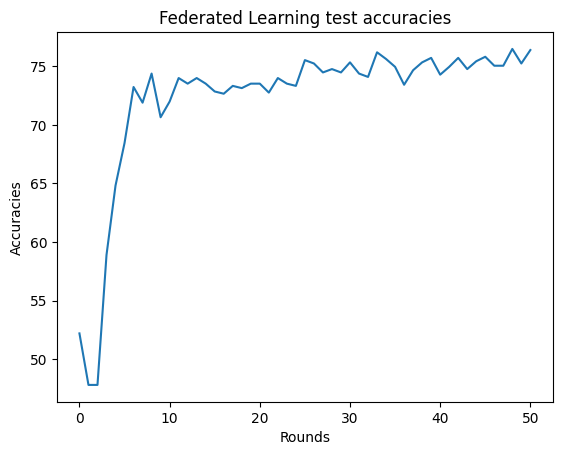

In [14]:
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [15]:
max(fl_acc)

tensor(76.4818, device='cuda:0')

## transfer learning

In [16]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


FL accuracy,▂▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇██████████████
FL loss,████▇▅▅▄▃▃▃▂▃▃▃▂▂▃▂▂▁▁▂▂▁▂▁▁▂▂▁▁▂▁▂▂▂▂▁▁
FL accuracy,76.38623
FL loss,0.03065



Epoch 1/100
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([44, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
tor

transfer training accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇██▇█▇██████████████████████
transfer validationaccuracy,▁▅▆▇▇██▇▇███▇████████████████████████▇██
transfer training accuracy,84.36842
transfer validationaccuracy,73.73949


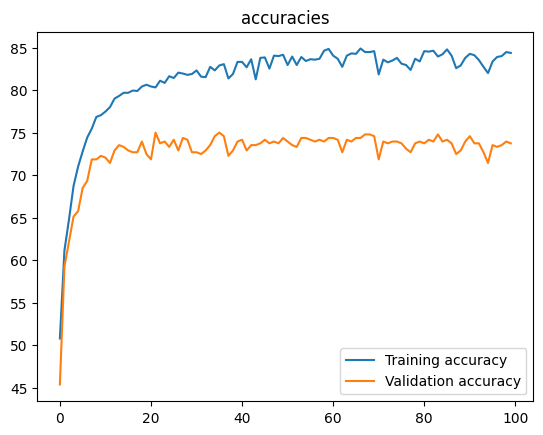

In [17]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'], name= 'transfer')
    loss, accuracy = test(net, azure_test_loader, configuration)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Transfer Learning

In [18]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "federated transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

In [19]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FTL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FTL, parameters_centralized)

In [20]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FTL, trainloader, valloader, configuration).to_client()


In [21]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
ftl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FTL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FTL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    ftl_acc.append(accuracy)
    metrics = {'FTL loss': loss,
               "FTL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FTL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-17 23:17:43,706	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'object_store_memory': 52888176230.0, 'node:__internal_head__': 1.0, 'memory': 113405744538.0, 'node:192.168.1.146': 1.0, 'GPU': 2.0, 'accelerator_type:G': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.041903138160705566 / accuracy 52.1988525390625
(ClientAppActor pid=123629) 
(ClientAppActor pid=123629) Epoch 1/100
(ClientAppActor pid=123629) Epoch 1: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=123629) Epoch 2: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=123629) Epoch 3: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=123629) Epoch 4: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=123629) Epoch 5: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=123629) Epoch 6: Training accuracy: 49.0455207824707 Testing accuracy: 50.877193450927734.
(ClientAppActor pid=123629) Epoch 7: Training accuracy: 61.23347854614258 Testing accuracy: 59.064327239990234.
(ClientAppActor pid=123629) Epoch 8: Training accuracy: 50.9544792175293 Tes

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.04075270540574018, {'accuracy': tensor(47.8968, device='cuda:0')}, 18.382284278000043)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04075270540574018 / accuracy 47.896751403808594
(ClientAppActor pid=123629)  [repeated 317x across cluster]
(ClientAppActor pid=123629) Epoch 84/100 [repeated 317x across cluster]
(ClientAppActor pid=123629) Epoch 4: Training accuracy: 53.19905090332031 Testing accuracy: 46.22641372680664. [repeated 349x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.03989215107525096, {'accuracy': tensor(70.4589, device='cuda:0')}, 23.897578481999517)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03989215107525096 / accuracy 70.45889282226562
(ClientAppActor pid=123629)  [repeated 236x across cluster]
(ClientAppActor pid=123629) Epoch 53/100 [repeated 236x across cluster]
(ClientAppActor pid=123628) Epoch 40: Training accuracy: 76.23188781738281 Testing accuracy: 78.61271667480469. [repeated 196x across cluster]
(ClientAppActor pid=123629)  [repeated 68x across cluster]
(ClientAppActor pid=123629) Epoch 71/100 [repeated 68x across cluster]
(ClientAppActor pid=123628) Epoch 90: Training accuracy: 76.52173614501953 Testing accuracy: 81.50289154052734. [repeated 68x across cluster]
(ClientAppActor pid=123628)  [repeated 116x across cluster]
(ClientAppActor pid=123628) Epoch 85/100 [repeated 116x across cluster]
(ClientAppActor pid=123629) Epoch 89: Training accuracy: 60.42654037475586 Testing accuracy: 57.54716873168945. [repeated 119x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.03798183623482199, {'accuracy': tensor(74.1874, device='cuda:0')}, 41.07539825299955)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03798183623482199 / accuracy 74.1873779296875


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 135x across cluster]
(ClientAppActor pid=123629) Epoch 3/100 [repeated 135x across cluster]
(ClientAppActor pid=123629) Epoch 4: Training accuracy: 70.379150390625 Testing accuracy: 64.15093994140625. [repeated 145x across cluster]
(ClientAppActor pid=123628)  [repeated 382x across cluster]
(ClientAppActor pid=123628) Epoch 90/100 [repeated 382x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.03574542788898244, {'accuracy': tensor(73.5182, device='cuda:0')}, 46.90687532499942)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03574542788898244 / accuracy 73.5181655883789
(ClientAppActor pid=123629) Epoch 5: Training accuracy: 71.51248168945312 Testing accuracy: 68.42105102539062. [repeated 380x across cluster]
(ClientAppActor pid=123629)  [repeated 180x across cluster]
(ClientAppActor pid=123629) Epoch 4/100 [repeated 180x across cluster]
(ClientAppActor pid=123628) Epoch 69: Training accuracy: 72.98577880859375 Testing accuracy: 65.0943374633789. [repeated 168x across cluster]
(ClientAppActor pid=123629)  [repeated 83x across cluster]
(ClientAppActor pid=123629) Epoch 47/100 [repeated 83x across cluster]
(ClientAppActor pid=123629) Epoch 51: Training accuracy: 76.6091079711914 Testing accuracy: 73.125. [repeated 87x across cluster]
(ClientAppActor pid=123628)  [repeated 114x across cluster]
(ClientAppActor pid=123628) Epoch 67/100 [repeated 114x across cluster]
(ClientAppActor pid=123628) Epoch 78: Training accuracy: 74.78260803222656 Testing accuracy: 77.45664978027344. [repe

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.03334476667291978, {'accuracy': tensor(75.8126, device='cuda:0')}, 62.90777933999925)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03334476667291978 / accuracy 75.8126220703125
(ClientAppActor pid=123628)  [repeated 386x across cluster]
(ClientAppActor pid=123628) Epoch 53/100 [repeated 386x across cluster]
(ClientAppActor pid=123628) Epoch 76: Training accuracy: 74.30249786376953 Testing accuracy: 76.02339172363281. [repeated 398x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.033163014580221736, {'accuracy': tensor(74.0918, device='cuda:0')}, 67.51916393800002)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.033163014580221736 / accuracy 74.09178161621094
(ClientAppActor pid=123628)  [repeated 240x across cluster]
(ClientAppActor pid=123628) Epoch 84/100 [repeated 240x across cluster]
(ClientAppActor pid=123629) Epoch 10: Training accuracy: 74.64454650878906 Testing accuracy: 66.98113250732422. [repeated 221x across cluster]
(ClientAppActor pid=123628)  [repeated 85x across cluster]
(ClientAppActor pid=123628) Epoch 50/100 [repeated 85x across cluster]
(ClientAppActor pid=123629) Epoch 29: Training accuracy: 74.40758514404297 Testing accuracy: 67.45282745361328. [repeated 96x across cluster]
(ClientAppActor pid=123629)  [repeated 67x across cluster]
(ClientAppActor pid=123629) Epoch 45/100 [repeated 67x across cluster]
(ClientAppActor pid=123629) Epoch 45: Training accuracy: 73.459716796875 Testing accuracy: 71.69811248779297. [repeated 52x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.032866688335643095, {'accuracy': tensor(73.6138, device='cuda:0')}, 86.03987626799972)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032866688335643095 / accuracy 73.61376953125
(ClientAppActor pid=123629)  [repeated 173x across cluster]
(ClientAppActor pid=123629) Epoch 56/100 [repeated 173x across cluster]
(ClientAppActor pid=123629) Epoch 74: Training accuracy: 76.66666412353516 Testing accuracy: 79.19075012207031. [repeated 209x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.03204204054439769, {'accuracy': tensor(75.1434, device='cuda:0')}, 91.81881265599986)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03204204054439769 / accuracy 75.14340209960938


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 283x across cluster]
(ClientAppActor pid=123629) Epoch 1/100 [repeated 283x across cluster]
(ClientAppActor pid=123629) Epoch 1: Training accuracy: 75.18355560302734 Testing accuracy: 76.02339172363281. [repeated 248x across cluster]
(ClientAppActor pid=123629)  [repeated 75x across cluster]
(ClientAppActor pid=123629) Epoch 24/100 [repeated 75x across cluster]
(ClientAppActor pid=123628) Epoch 53: Training accuracy: 77.39130401611328 Testing accuracy: 79.19075012207031. [repeated 74x across cluster]
(ClientAppActor pid=123629)  [repeated 103x across cluster]
(ClientAppActor pid=123629) Epoch 55/100 [repeated 103x across cluster]
(ClientAppActor pid=123629) Epoch 55: Training accuracy: 73.71512603759766 Testing accuracy: 75.4385986328125. [repeated 107x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.032932754825143254, {'accuracy': tensor(72.5621, device='cuda:0')}, 105.4210467769999)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032932754825143254 / accuracy 72.56214141845703
(ClientAppActor pid=123629)  [repeated 403x across cluster]
(ClientAppActor pid=123629) Epoch 87/100 [repeated 403x across cluster]
(ClientAppActor pid=123629) Epoch 90: Training accuracy: 76.1848373413086 Testing accuracy: 71.2264175415039. [repeated 403x across cluster]
(ClientAppActor pid=123629)  [repeated 118x across cluster]
(ClientAppActor pid=123629) Epoch 33/100 [repeated 118x across cluster]
(ClientAppActor pid=123628) Epoch 72: Training accuracy: 77.55101776123047 Testing accuracy: 76.875. [repeated 118x across cluster]
(ClientAppActor pid=123629)  [repeated 55x across cluster]
(ClientAppActor pid=123629) Epoch 55/100 [repeated 55x across cluster]
(ClientAppActor pid=123629) Epoch 54: Training accuracy: 71.95301055908203 Testing accuracy: 72.51461791992188. [repeated 50x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.031397342681884766, {'accuracy': tensor(75.5258, device='cuda:0')}, 122.53958232999958)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031397342681884766 / accuracy 75.52581024169922
(ClientAppActor pid=123629)  [repeated 47x across cluster]
(ClientAppActor pid=123629) Epoch 2/100 [repeated 47x across cluster]
(ClientAppActor pid=123629) Epoch 1: Training accuracy: 72.83406829833984 Testing accuracy: 75.4385986328125. [repeated 47x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.030797194032108084, {'accuracy': tensor(76.3862, device='cuda:0')}, 126.50575796699923)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030797194032108084 / accuracy 76.38623046875
(ClientAppActor pid=123629)  [repeated 495x across cluster]
(ClientAppActor pid=123629) Epoch 57/100 [repeated 495x across cluster]
(ClientAppActor pid=123629) Epoch 56: Training accuracy: 75.03671264648438 Testing accuracy: 78.3625717163086. [repeated 494x across cluster]
(ClientAppActor pid=123629)  [repeated 96x across cluster]
(ClientAppActor pid=123629) Epoch 2/100 [repeated 96x across cluster]
(ClientAppActor pid=123629) Epoch 1: Training accuracy: 74.28910064697266 Testing accuracy: 70.75471496582031. [repeated 96x across cluster]
(ClientAppActor pid=123629)  [repeated 126x across cluster]
(ClientAppActor pid=123629) Epoch 19/100 [repeated 126x across cluster]
(ClientAppActor pid=123629) Epoch 18: Training accuracy: 75.82938385009766 Testing accuracy: 70.28302001953125. [repeated 127x across cluster]
(ClientAppActor pid=123629)  [repeated 28x across cluster]
(ClientAppActor pid=123629) Epoch 47/100 [repea

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.031457108609816604, {'accuracy': tensor(75.5258, device='cuda:0')}, 145.18222130599952)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031457108609816604 / accuracy 75.52581024169922
(ClientAppActor pid=123629)  [repeated 350x across cluster]
(ClientAppActor pid=123629) Epoch 47/100 [repeated 350x across cluster]
(ClientAppActor pid=123629) Epoch 46: Training accuracy: 75.35545349121094 Testing accuracy: 70.28302001953125. [repeated 349x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.03191168869242949, {'accuracy': tensor(73.8050, device='cuda:0')}, 149.58565093199923)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03191168869242949 / accuracy 73.80496978759766
(ClientAppActor pid=123628)  [repeated 157x across cluster]
(ClientAppActor pid=123628) Epoch 36/100 [repeated 157x across cluster]
(ClientAppActor pid=123628) Epoch 35: Training accuracy: 76.50514221191406 Testing accuracy: 77.19298553466797. [repeated 157x across cluster]
(ClientAppActor pid=123629)  [repeated 145x across cluster]
(ClientAppActor pid=123629) Epoch 42/100 [repeated 145x across cluster]
(ClientAppActor pid=123629) Epoch 41: Training accuracy: 79.59183502197266 Testing accuracy: 74.375. [repeated 145x across cluster]
(ClientAppActor pid=123629)  [repeated 166x across cluster]
(ClientAppActor pid=123629) Epoch 65/100 [repeated 166x across cluster]
(ClientAppActor pid=123629) Epoch 64: Training accuracy: 78.9638900756836 Testing accuracy: 74.375. [repeated 167x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.030291438102722168, {'accuracy': tensor(75.9082, device='cuda:0')}, 167.43758708599944)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030291438102722168 / accuracy 75.90821838378906
(ClientAppActor pid=123629)  [repeated 79x across cluster]
(ClientAppActor pid=123629) Epoch 19/100 [repeated 79x across cluster]
(ClientAppActor pid=123629) Epoch 18: Training accuracy: 79.43485260009766 Testing accuracy: 75.625. [repeated 78x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.030833384569953468, {'accuracy': tensor(74.9522, device='cuda:0')}, 172.3355910299997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030833384569953468 / accuracy 74.95220184326172
(ClientAppActor pid=123629)  [repeated 453x across cluster]
(ClientAppActor pid=123629) Epoch 57/100 [repeated 453x across cluster]
(ClientAppActor pid=123629) Epoch 56: Training accuracy: 77.82608795166016 Testing accuracy: 76.87861633300781. [repeated 453x across cluster]
(ClientAppActor pid=123628)  [repeated 238x across cluster]
(ClientAppActor pid=123628) Epoch 53/100 [repeated 238x across cluster]
(ClientAppActor pid=123628) Epoch 52: Training accuracy: 76.21145629882812 Testing accuracy: 79.53216552734375. [repeated 238x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.031115914092344397, {'accuracy': tensor(74.5698, device='cuda:0')}, 183.31990246899932)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.031115914092344397 / accuracy 74.56978607177734


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 66x across cluster]
(ClientAppActor pid=123629) Epoch 1/100 [repeated 66x across cluster]
(ClientAppActor pid=123629) Epoch 100: Training accuracy: 76.540283203125 Testing accuracy: 69.3396224975586. [repeated 67x across cluster]
(ClientAppActor pid=123629)  [repeated 140x across cluster]
(ClientAppActor pid=123629) Epoch 27/100 [repeated 140x across cluster]
(ClientAppActor pid=123629) Epoch 26: Training accuracy: 76.540283203125 Testing accuracy: 67.92453002929688. [repeated 139x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.030789357774397907, {'accuracy': tensor(74.9522, device='cuda:0')}, 192.28613030299948)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030789357774397907 / accuracy 74.95220184326172
(ClientAppActor pid=123629)  [repeated 435x across cluster]
(ClientAppActor pid=123629) Epoch 88/100 [repeated 435x across cluster]
(ClientAppActor pid=123629) Epoch 87: Training accuracy: 77.2393569946289 Testing accuracy: 77.19298553466797. [repeated 435x across cluster]
(ClientAppActor pid=123628)  [repeated 203x across cluster]
(ClientAppActor pid=123628) Epoch 79/100 [repeated 203x across cluster]
(ClientAppActor pid=123628) Epoch 78: Training accuracy: 76.77725219726562 Testing accuracy: 72.64151000976562. [repeated 204x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.030349594705245075, {'accuracy': tensor(74.6654, device='cuda:0')}, 201.89625459599938)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030349594705245075 / accuracy 74.66539001464844


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 42x across cluster]
(ClientAppActor pid=123629) Epoch 8/100 [repeated 42x across cluster]
(ClientAppActor pid=123629) Epoch 7: Training accuracy: 76.65198516845703 Testing accuracy: 76.60818481445312. [repeated 41x across cluster]
(ClientAppActor pid=123629)  [repeated 151x across cluster]
(ClientAppActor pid=123629) Epoch 33/100 [repeated 151x across cluster]
(ClientAppActor pid=123629) Epoch 32: Training accuracy: 75.47724151611328 Testing accuracy: 76.02339172363281. [repeated 151x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.029541278586668128, {'accuracy': tensor(77.9159, device='cuda:0')}, 213.62764675800008)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029541278586668128 / accuracy 77.9158706665039
(ClientAppActor pid=123629)  [repeated 252x across cluster]
(ClientAppActor pid=123629) Epoch 9/100 [repeated 252x across cluster]
(ClientAppActor pid=123629) Epoch 8: Training accuracy: 76.6091079711914 Testing accuracy: 71.25. [repeated 252x across cluster]
(ClientAppActor pid=123629)  [repeated 365x across cluster]
(ClientAppActor pid=123629) Epoch 89/100 [repeated 365x across cluster]
(ClientAppActor pid=123629) Epoch 88: Training accuracy: 78.840576171875 Testing accuracy: 79.19075012207031. [repeated 366x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.030328996041241812, {'accuracy': tensor(74.8566, device='cuda:0')}, 219.2421539779998)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030328996041241812 / accuracy 74.85659790039062
(ClientAppActor pid=123628)  [repeated 339x across cluster]
(ClientAppActor pid=123628) Epoch 28/100 [repeated 339x across cluster]
(ClientAppActor pid=123628) Epoch 27: Training accuracy: 78.98550415039062 Testing accuracy: 77.45664978027344. [repeated 339x across cluster]
(ClientAppActor pid=123628)  [repeated 42x across cluster]
(ClientAppActor pid=123628) Epoch 70/100 [repeated 42x across cluster]
(ClientAppActor pid=123628) Epoch 69: Training accuracy: 78.840576171875 Testing accuracy: 78.61271667480469. [repeated 42x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.02955342040342443, {'accuracy': tensor(77.3423, device='cuda:0')}, 233.0056486149997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02955342040342443 / accuracy 77.34225463867188
(ClientAppActor pid=123629)  [repeated 39x across cluster]
(ClientAppActor pid=123629) Epoch 4/100 [repeated 39x across cluster]
(ClientAppActor pid=123629) Epoch 3: Training accuracy: 76.94567108154297 Testing accuracy: 78.9473648071289. [repeated 38x across cluster]
(ClientAppActor pid=123629)  [repeated 163x across cluster]
(ClientAppActor pid=123629) Epoch 47/100 [repeated 163x across cluster]
(ClientAppActor pid=123629) Epoch 46: Training accuracy: 77.2393569946289 Testing accuracy: 80.11695861816406. [repeated 163x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.03101154285318711, {'accuracy': tensor(74.5698, device='cuda:0')}, 241.9266592949998)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03101154285318711 / accuracy 74.56978607177734
(ClientAppActor pid=123629)  [repeated 353x across cluster]
(ClientAppActor pid=123629) Epoch 67/100 [repeated 353x across cluster]
(ClientAppActor pid=123629) Epoch 66: Training accuracy: 78.08056640625 Testing accuracy: 73.11320495605469. [repeated 353x across cluster]
(ClientAppActor pid=123628)  [repeated 69x across cluster]
(ClientAppActor pid=123628) Epoch 8/100 [repeated 69x across cluster]
(ClientAppActor pid=123628) Epoch 7: Training accuracy: 75.91777038574219 Testing accuracy: 78.3625717163086. [repeated 69x across cluster]
(ClientAppActor pid=123628)  [repeated 158x across cluster]
(ClientAppActor pid=123628) Epoch 52/100 [repeated 158x across cluster]
(ClientAppActor pid=123628) Epoch 51: Training accuracy: 79.27536010742188 Testing accuracy: 78.03468322753906. [repeated 159x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.030185397933511174, {'accuracy': tensor(75.3346, device='cuda:0')}, 254.93818241400004)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.030185397933511174 / accuracy 75.33460998535156


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 243x across cluster]
(ClientAppActor pid=123629) Epoch 18/100 [repeated 243x across cluster]
(ClientAppActor pid=123629) Epoch 17: Training accuracy: 80.21977996826172 Testing accuracy: 74.375. [repeated 242x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.030121119583354276, {'accuracy': tensor(75.3346, device='cuda:0')}, 261.441439145)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030121119583354276 / accuracy 75.33460998535156
(ClientAppActor pid=123629)  [repeated 471x across cluster]
(ClientAppActor pid=123629) Epoch 40/100 [repeated 471x across cluster]
(ClientAppActor pid=123629) Epoch 39: Training accuracy: 78.31753540039062 Testing accuracy: 70.28302001953125. [repeated 471x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.029306888580322266, {'accuracy': tensor(78.0115, device='cuda:0')}, 268.7365764569995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029306888580322266 / accuracy 78.011474609375


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 137x across cluster]
(ClientAppActor pid=123629) Epoch 1/100 [repeated 137x across cluster]
(ClientAppActor pid=123628) Epoch 1: Training accuracy: 76.50514221191406 Testing accuracy: 77.19298553466797. [repeated 137x across cluster]
(ClientAppActor pid=123628)  [repeated 137x across cluster]
(ClientAppActor pid=123628) Epoch 23/100 [repeated 137x across cluster]
(ClientAppActor pid=123628) Epoch 22: Training accuracy: 79.90580749511719 Testing accuracy: 73.75. [repeated 137x across cluster]
(ClientAppActor pid=123629)  [repeated 194x across cluster]
(ClientAppActor pid=123629) Epoch 34/100 [repeated 194x across cluster]
(ClientAppActor pid=123629) Epoch 33: Training accuracy: 77.96208190917969 Testing accuracy: 73.58490753173828. [repeated 195x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.030253883670358098, {'accuracy': tensor(75.5258, device='cuda:0')}, 282.42644134999955)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030253883670358098 / accuracy 75.52581024169922
(ClientAppActor pid=123629)  [repeated 284x across cluster]
(ClientAppActor pid=123629) Epoch 22/100 [repeated 284x across cluster]
(ClientAppActor pid=123629) Epoch 21: Training accuracy: 79.74882507324219 Testing accuracy: 76.25. [repeated 283x across cluster]
(ClientAppActor pid=123628)  [repeated 149x across cluster]
(ClientAppActor pid=123628) Epoch 67/100 [repeated 149x across cluster]
(ClientAppActor pid=123628) Epoch 66: Training accuracy: 78.98550415039062 Testing accuracy: 78.61271667480469. [repeated 150x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.029499716618481803, {'accuracy': tensor(76.9598, device='cuda:0')}, 293.74006732)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029499716618481803 / accuracy 76.95984649658203
(ClientAppActor pid=123629)  [repeated 41x across cluster]
(ClientAppActor pid=123629) Epoch 3/100 [repeated 41x across cluster]
(ClientAppActor pid=123629) Epoch 2: Training accuracy: 78.8069076538086 Testing accuracy: 70.0. [repeated 40x across cluster]
(ClientAppActor pid=123629)  [repeated 85x across cluster]
(ClientAppActor pid=123629) Epoch 28/100 [repeated 85x across cluster]
(ClientAppActor pid=123629) Epoch 27: Training accuracy: 77.23704528808594 Testing accuracy: 67.5. [repeated 85x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.03003846196567311, {'accuracy': tensor(76.0994, device='cuda:0')}, 304.16327000099955)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03003846196567311 / accuracy 76.09942626953125
(ClientAppActor pid=123629)  [repeated 349x across cluster]
(ClientAppActor pid=123629) Epoch 26/100 [repeated 349x across cluster]
(ClientAppActor pid=123629) Epoch 25: Training accuracy: 79.85507202148438 Testing accuracy: 76.87861633300781. [repeated 349x across cluster]
(ClientAppActor pid=123628)  [repeated 317x across cluster]
(ClientAppActor pid=123628) Epoch 59/100 [repeated 317x across cluster]
(ClientAppActor pid=123628) Epoch 58: Training accuracy: 77.53304290771484 Testing accuracy: 79.53216552734375. [repeated 318x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.03016761120627908, {'accuracy': tensor(75.9082, device='cuda:0')}, 312.6355561399996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03016761120627908 / accuracy 75.90821838378906


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123628)  [repeated 88x across cluster]
(ClientAppActor pid=123628) Epoch 41/100 [repeated 88x across cluster]
(ClientAppActor pid=123628) Epoch 40: Training accuracy: 80.28985595703125 Testing accuracy: 78.61271667480469. [repeated 87x across cluster]
(ClientAppActor pid=123629)  [repeated 184x across cluster]
(ClientAppActor pid=123629) Epoch 24/100 [repeated 184x across cluster]
(ClientAppActor pid=123629) Epoch 23: Training accuracy: 78.67298889160156 Testing accuracy: 73.58490753173828. [repeated 184x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.02950325082330143, {'accuracy': tensor(77.1511, device='cuda:0')}, 324.52102707299946)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02950325082330143 / accuracy 77.15105438232422
(ClientAppActor pid=123629)  [repeated 178x across cluster]
(ClientAppActor pid=123629) Epoch 7/100 [repeated 178x across cluster]
(ClientAppActor pid=123629) Epoch 6: Training accuracy: 76.94567108154297 Testing accuracy: 78.9473648071289. [repeated 178x across cluster]
(ClientAppActor pid=123628)  [repeated 365x across cluster]
(ClientAppActor pid=123628) Epoch 74/100 [repeated 365x across cluster]
(ClientAppActor pid=123628) Epoch 73: Training accuracy: 79.27786254882812 Testing accuracy: 76.25. [repeated 366x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.03030713165507597, {'accuracy': tensor(75.4302, device='cuda:0')}, 332.52390981200006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03030713165507597 / accuracy 75.43021392822266


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123628)  [repeated 52x across cluster]
(ClientAppActor pid=123628) Epoch 19/100 [repeated 52x across cluster]
(ClientAppActor pid=123628) Epoch 18: Training accuracy: 79.56521606445312 Testing accuracy: 78.03468322753906. [repeated 51x across cluster]
(ClientAppActor pid=123628)  [repeated 124x across cluster]
(ClientAppActor pid=123628) Epoch 27/100 [repeated 124x across cluster]
(ClientAppActor pid=123628) Epoch 26: Training accuracy: 78.6499252319336 Testing accuracy: 75.625. [repeated 124x across cluster]
(ClientAppActor pid=123628)  [repeated 153x across cluster]
(ClientAppActor pid=123628) Epoch 63/100 [repeated 153x across cluster]
(ClientAppActor pid=123628) Epoch 62: Training accuracy: 77.97357177734375 Testing accuracy: 80.11695861816406. [repeated 153x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.029722925494698918, {'accuracy': tensor(76.9598, device='cuda:0')}, 346.84174659699966)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029722925494698918 / accuracy 76.95984649658203
(ClientAppActor pid=123629)  [repeated 412x across cluster]
(ClientAppActor pid=123629) Epoch 76/100 [repeated 412x across cluster]
(ClientAppActor pid=123629) Epoch 75: Training accuracy: 80.37676239013672 Testing accuracy: 75.0. [repeated 412x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.02943898649776683, {'accuracy': tensor(76.7686, device='cuda:0')}, 354.3486558779996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02943898649776683 / accuracy 76.76864624023438
(ClientAppActor pid=123628)  [repeated 88x across cluster]
(ClientAppActor pid=123628) Epoch 2/100 [repeated 88x across cluster]
(ClientAppActor pid=123628) Epoch 1: Training accuracy: 79.74882507324219 Testing accuracy: 75.0. [repeated 88x across cluster]
(ClientAppActor pid=123628)  [repeated 72x across cluster]
(ClientAppActor pid=123628) Epoch 52/100 [repeated 72x across cluster]
(ClientAppActor pid=123628) Epoch 51: Training accuracy: 80.21977996826172 Testing accuracy: 75.625. [repeated 72x across cluster]
(ClientAppActor pid=123628)  [repeated 152x across cluster]
(ClientAppActor pid=123628) Epoch 75/100 [repeated 152x across cluster]
(ClientAppActor pid=123628) Epoch 74: Training accuracy: 80.28985595703125 Testing accuracy: 78.03468322753906. [repeated 152x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.031221147845773137, {'accuracy': tensor(74.7610, device='cuda:0')}, 368.08173663899925)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031221147845773137 / accuracy 74.76099395751953
(ClientAppActor pid=123629)  [repeated 320x across cluster]
(ClientAppActor pid=123629) Epoch 47/100 [repeated 320x across cluster]
(ClientAppActor pid=123629) Epoch 46: Training accuracy: 78.26725769042969 Testing accuracy: 80.70175170898438. [repeated 321x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.02976917869904462, {'accuracy': tensor(76.8642, device='cuda:0')}, 373.2525627469995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02976917869904462 / accuracy 76.86424255371094
(ClientAppActor pid=123629)  [repeated 368x across cluster]
(ClientAppActor pid=123629) Epoch 72/100 [repeated 368x across cluster]
(ClientAppActor pid=123629) Epoch 71: Training accuracy: 78.41410064697266 Testing accuracy: 78.3625717163086. [repeated 367x across cluster]
(ClientAppActor pid=123629)  [repeated 81x across cluster]
(ClientAppActor pid=123629) Epoch 5/100 [repeated 81x across cluster]
(ClientAppActor pid=123629) Epoch 4: Training accuracy: 79.74882507324219 Testing accuracy: 75.625. [repeated 81x across cluster]
(ClientAppActor pid=123629)  [repeated 95x across cluster]
(ClientAppActor pid=123629) Epoch 48/100 [repeated 95x across cluster]
(ClientAppActor pid=123629) Epoch 47: Training accuracy: 80.21977996826172 Testing accuracy: 75.625. [repeated 95x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.030490791096406823, {'accuracy': tensor(75.1434, device='cuda:0')}, 390.03509231099997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030490791096406823 / accuracy 75.14340209960938
(ClientAppActor pid=123629)  [repeated 109x across cluster]
(ClientAppActor pid=123629) Epoch 100/100 [repeated 109x across cluster]
(ClientAppActor pid=123629) Epoch 100: Training accuracy: 79.90580749511719 Testing accuracy: 68.75. [repeated 111x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.03001195192337036, {'accuracy': tensor(76.2906, device='cuda:0')}, 395.185704603)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123628)  [repeated 400x across cluster]
(ClientAppActor pid=123628) Epoch 100/100 [repeated 400x across cluster]
(ClientAppActor pid=123628) Epoch 100: Training accuracy: 79.85507202148438 Testing accuracy: 77.45664978027344. [repeated 400x across cluster]
Server-side evaluation loss 0.03001195192337036 / accuracy 76.29063415527344
(ClientAppActor pid=123628)  [repeated 392x across cluster]
(ClientAppActor pid=123628) Epoch 92/100 [repeated 392x across cluster]
(ClientAppActor pid=123628) Epoch 91: Training accuracy: 79.71014404296875 Testing accuracy: 78.61271667480469. [repeated 391x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.029449634692248178, {'accuracy': tensor(76.9598, device='cuda:0')}, 401.35368463899977)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029449634692248178 / accuracy 76.95984649658203
(ClientAppActor pid=123628)  [repeated 64x across cluster]
(ClientAppActor pid=123628) Epoch 39/100 [repeated 64x across cluster]
(ClientAppActor pid=123628) Epoch 38: Training accuracy: 79.29515075683594 Testing accuracy: 81.28655242919922. [repeated 63x across cluster]
(ClientAppActor pid=123629)  [repeated 75x across cluster]
(ClientAppActor pid=123629) Epoch 41/100 [repeated 75x across cluster]
(ClientAppActor pid=123629) Epoch 40: Training accuracy: 80.84772491455078 Testing accuracy: 75.625. [repeated 75x across cluster]
(ClientAppActor pid=123629)  [repeated 185x across cluster]
(ClientAppActor pid=123629) Epoch 64/100 [repeated 185x across cluster]
(ClientAppActor pid=123629) Epoch 63: Training accuracy: 79.90580749511719 Testing accuracy: 75.625. [repeated 185x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.030022158342249253, {'accuracy': tensor(76.2906, device='cuda:0')}, 419.04348256399953)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030022158342249253 / accuracy 76.29063415527344
(ClientAppActor pid=123629)  [repeated 175x across cluster]
(ClientAppActor pid=123629) Epoch 30/100 [repeated 175x across cluster]
(ClientAppActor pid=123629) Epoch 29: Training accuracy: 80.5797119140625 Testing accuracy: 78.03468322753906. [repeated 175x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.02937433123588562, {'accuracy': tensor(77.0555, device='cuda:0')}, 423.7971543579997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02937433123588562 / accuracy 77.05545043945312
(ClientAppActor pid=123629)  [repeated 373x across cluster]
(ClientAppActor pid=123629) Epoch 46/100 [repeated 373x across cluster]
(ClientAppActor pid=123629) Epoch 45: Training accuracy: 79.74882507324219 Testing accuracy: 70.0. [repeated 373x across cluster]
(ClientAppActor pid=123629)  [repeated 78x across cluster]
(ClientAppActor pid=123629) Epoch 71/100 [repeated 78x across cluster]
(ClientAppActor pid=123629) Epoch 70: Training accuracy: 80.06279754638672 Testing accuracy: 73.125. [repeated 78x across cluster]
(ClientAppActor pid=123629)  [repeated 138x across cluster]
(ClientAppActor pid=123629) Epoch 13/100 [repeated 138x across cluster]
(ClientAppActor pid=123629) Epoch 12: Training accuracy: 80.0 Testing accuracy: 79.76878356933594. [repeated 138x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.029715594123391545, {'accuracy': tensor(76.8642, device='cuda:0')}, 439.4822038019993)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029715594123391545 / accuracy 76.86424255371094
(ClientAppActor pid=123629)  [repeated 195x across cluster]
(ClientAppActor pid=123629) Epoch 43/100 [repeated 195x across cluster]
(ClientAppActor pid=123629) Epoch 42: Training accuracy: 77.97357177734375 Testing accuracy: 80.11695861816406. [repeated 195x across cluster]
(ClientAppActor pid=123628)  [repeated 290x across cluster]
(ClientAppActor pid=123628) Epoch 65/100 [repeated 290x across cluster]
(ClientAppActor pid=123628) Epoch 64: Training accuracy: 80.0 Testing accuracy: 78.61271667480469. [repeated 291x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.029229474418303546, {'accuracy': tensor(77.2467, device='cuda:0')}, 449.4869032859997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.029229474418303546 / accuracy 77.24665069580078


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123629)  [repeated 43x across cluster]
(ClientAppActor pid=123629) Epoch 4/100 [repeated 43x across cluster]
(ClientAppActor pid=123629) Epoch 3: Training accuracy: 79.74882507324219 Testing accuracy: 74.375. [repeated 42x across cluster]
(ClientAppActor pid=123629)  [repeated 70x across cluster]
(ClientAppActor pid=123629) Epoch 32/100 [repeated 70x across cluster]
(ClientAppActor pid=123629) Epoch 31: Training accuracy: 81.00470733642578 Testing accuracy: 75.625. [repeated 70x across cluster]
(ClientAppActor pid=123629)  [repeated 281x across cluster]
(ClientAppActor pid=123629) Epoch 100/100 [repeated 281x across cluster]
(ClientAppActor pid=123629) Epoch 100: Training accuracy: 78.6956558227539 Testing accuracy: 76.87861633300781. [repeated 282x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.02991327818702249, {'accuracy': tensor(76.5774, device='cuda:0')}, 461.02818093299993)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02991327818702249 / accuracy 76.57743835449219
(ClientAppActor pid=123628)  [repeated 389x across cluster]
(ClientAppActor pid=123628) Epoch 76/100 [repeated 389x across cluster]
(ClientAppActor pid=123628) Epoch 75: Training accuracy: 79.88252258300781 Testing accuracy: 80.70175170898438. [repeated 388x across cluster]
(ClientAppActor pid=123629)  [repeated 43x across cluster]
(ClientAppActor pid=123629) Epoch 91/100 [repeated 43x across cluster]
(ClientAppActor pid=123629) Epoch 90: Training accuracy: 78.90995025634766 Testing accuracy: 74.52830505371094. [repeated 44x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.02975296272951014, {'accuracy': tensor(76.7686, device='cuda:0')}, 474.0133975809995)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.02975296272951014 / accuracy 76.76864624023438


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=123628)  [repeated 87x across cluster]
(ClientAppActor pid=123628) Epoch 71/100 [repeated 87x across cluster]
(ClientAppActor pid=123628) Epoch 70: Training accuracy: 78.08056640625 Testing accuracy: 69.3396224975586. [repeated 86x across cluster]
(ClientAppActor pid=123629)  [repeated 253x across cluster]
(ClientAppActor pid=123629) Epoch 31/100 [repeated 253x across cluster]
(ClientAppActor pid=123629) Epoch 30: Training accuracy: 79.29515075683594 Testing accuracy: 81.28655242919922. [repeated 254x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (45, 0.02868367643917308, {'accuracy': tensor(78.1071, device='cuda:0')}, 483.38769679100005)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02868367643917308 / accuracy 78.10707092285156
(ClientAppActor pid=123629)  [repeated 317x across cluster]
(ClientAppActor pid=123629) Epoch 49/100 [repeated 317x across cluster]
(ClientAppActor pid=123629) Epoch 48: Training accuracy: 79.73567962646484 Testing accuracy: 81.28655242919922. [repeated 316x across cluster]
(ClientAppActor pid=123628)  [repeated 147x across cluster]
(ClientAppActor pid=123628) Epoch 95/100 [repeated 147x across cluster]
(ClientAppActor pid=123628) Epoch 94: Training accuracy: 81.16169738769531 Testing accuracy: 75.625. [repeated 148x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.02932607601670658, {'accuracy': tensor(77.3423, device='cuda:0')}, 491.7174282649994)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02932607601670658 / accuracy 77.34225463867188
(ClientAppActor pid=123629)  [repeated 66x across cluster]
(ClientAppActor pid=123629) Epoch 20/100 [repeated 66x across cluster]
(ClientAppActor pid=123629) Epoch 19: Training accuracy: 80.69073486328125 Testing accuracy: 75.0. [repeated 65x across cluster]
(ClientAppActor pid=123628)  [repeated 146x across cluster]
(ClientAppActor pid=123628) Epoch 63/100 [repeated 146x across cluster]
(ClientAppActor pid=123628) Epoch 62: Training accuracy: 81.159423828125 Testing accuracy: 79.19075012207031. [repeated 146x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.02970979143591488, {'accuracy': tensor(77.0555, device='cuda:0')}, 505.5446608459997)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02970979143591488 / accuracy 77.05545043945312
(ClientAppActor pid=123629)  [repeated 238x across cluster]
(ClientAppActor pid=123629) Epoch 21/100 [repeated 238x across cluster]
(ClientAppActor pid=123629) Epoch 20: Training accuracy: 78.79146575927734 Testing accuracy: 73.58490753173828. [repeated 238x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.030266078079448026, {'accuracy': tensor(75.7170, device='cuda:0')}, 510.91401197399955)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030266078079448026 / accuracy 75.7170181274414
(ClientAppActor pid=123628)  [repeated 356x across cluster]
(ClientAppActor pid=123628) Epoch 1/100 [repeated 356x across cluster]
(ClientAppActor pid=123629) Epoch 100: Training accuracy: 79.00146484375 Testing accuracy: 80.70175170898438. [repeated 357x across cluster]
(ClientAppActor pid=123628)  [repeated 133x across cluster]
(ClientAppActor pid=123628) Epoch 12/100 [repeated 133x across cluster]
(ClientAppActor pid=123628) Epoch 11: Training accuracy: 75.35545349121094 Testing accuracy: 66.50943756103516. [repeated 132x across cluster]
(ClientAppActor pid=123629)  [repeated 173x across cluster]
(ClientAppActor pid=123629) Epoch 44/100 [repeated 173x across cluster]
(ClientAppActor pid=123629) Epoch 43: Training accuracy: 81.3043441772461 Testing accuracy: 78.03468322753906. [repeated 173x across cluster]
(ClientAppActor pid=123629)  [repeated 57x across cluster]
(ClientAppActor pid=123629) Epoch 64/100 [r

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.02917620539665222, {'accuracy': tensor(77.5335, device='cuda:0')}, 528.4481169869996)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02917620539665222 / accuracy 77.53346252441406
(ClientAppActor pid=123629)  [repeated 340x across cluster]
(ClientAppActor pid=123629) Epoch 45/100 [repeated 340x across cluster]
(ClientAppActor pid=123629) Epoch 44: Training accuracy: 79.85507202148438 Testing accuracy: 78.61271667480469. [repeated 339x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.028802692890167236, {'accuracy': tensor(78.1071, device='cuda:0')}, 532.4254537009992)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 532.46s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.23023545742034912\n'
INFO :      	 '\tround 2: 0.1936951960836138\n'
INFO :      	 '\tround 3: 0.18013602495193481\n'
INFO :      	 '\tround 4: 0.17612176282065256\n'
INFO :      	 '\tround 5: 0.2094687024752299\n'
INFO :      	 '\tround 6: 0.18350027004877725\n'
INFO :      	 '\tround 7: 0.1666706715311323\n'
INFO :      	 '\tround 8: 0.16300779581069946\n'
INFO :      	 '\tround 9: 0.19463730851809183\n'
INFO :      	 '\tround 10: 0.1531966073172433\n'
INFO :      	 '\tround 11: 0.17990675568580627\n'
INFO :      	 '\tround 1

Server-side evaluation loss 0.028802692890167236 / accuracy 78.10707092285156


Text(0.5, 0, 'Rounds')

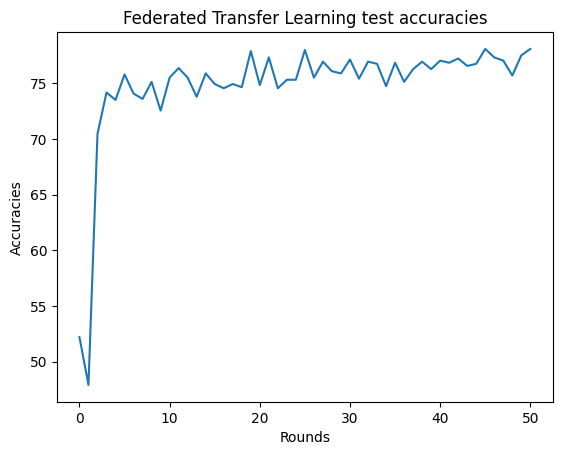

In [22]:
f = []
for i in ftl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [23]:
max(ftl_acc)

tensor(78.1071, device='cuda:0')